In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os, json, pickle
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

In [13]:
train_dataset = BertSeqDataset.from_dgp_pickle("/home/andrew/go_metric/dgp_data/data/terms.pkl", 
                                                "/home/andrew/go_metric/dgp_data/data/train_data.pkl")
test_dataset = BertSeqDataset.from_dgp_pickle("/home/andrew/go_metric/dgp_data/data/terms.pkl", 
                                                "/home/andrew/go_metric/dgp_data/data/test_data.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 64, "collate_fn":collate_seqs}

train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)


def get_sparse_probs(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(model.device)
            m_probs = model(X)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

import pickle
with open("/home/andrew/go_metric/dgp_data/data/terms.pkl", 'rb') as f:
    terms = pickle.load(f)
    terms = terms['terms'].to_list()

In [10]:
def prot_dict_from_pkl(term_fn, prot_fn):
    import pickle
    with open(term_fn, 'rb') as f:
        terms = pickle.load(f)['terms'].to_list()
    with open(prot_fn, 'rb') as f:
        df = pickle.load(f)
    prot_names = df['proteins'].to_list()
    sequences = df['sequences'].to_list()
    prot_dict = {}
    for prot_id, annotations in zip(df['proteins'], df['prop_annotations']):
        prot_dict[prot_id] = annotations
    return prot_dict

train_dict = prot_dict_from_pkl("/home/andrew/go_metric/dgp_data/data/terms.pkl", 
                                "/home/andrew/go_metric/dgp_data/data/train_data.pkl")

In [6]:
with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}

test_ia = np.zeros(len(terms))
skip_count = 0
for i, test_id in enumerate(terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]
    else:
        skip_count += 1
print(f"{skip_count/len(test_ia)*100}% skipped")

0.8520790729379687% skipped


# BLAST Utility Functions


In [7]:
def load_diamond_scores(hit_fn):
    diamond_scores = {}
    with open(hit_fn) as f:
        for line in f:
            it = line.strip().split()
            if it[0] not in diamond_scores:
                diamond_scores[it[0]] = {}
            diamond_scores[it[0]][it[1]] = float(it[2])
    return diamond_scores

def blast_hit_to_pred(train_dict, diamond_scores, pred_ids):
    blast_preds = {}
    for prot_id in pred_ids:
        annots = {}
        if(prot_id in diamond_scores):
            sim_prots = diamond_scores[prot_id] #Similar prots in training
            allgos = set()
            total_score = 0.0
            for pid, score in sim_prots.items():
                allgos |= set(train_dict[pid]) #GO Terms for each similar prot
                total_score += score
            allgos = list(sorted(allgos))
            sim = np.zeros(len(allgos), dtype=np.float32)
            for j, go_id in enumerate(allgos):
                s = 0.0
                for p_id, score in sim_prots.items():
                    if go_id in train_dict[p_id]:
                        s += score
                sim[j] = s / total_score
            for go_id, score in zip(allgos, sim):
                annots[go_id] = score
        blast_preds[prot_id] = annots
    return blast_preds

from scipy.sparse import csr_matrix, dok_matrix, lil_matrix
def score_dict_to_sparse_matrix(protein_annotation_dict, term_list, prot_id_list):
    term_col_mappings = {term:i for i, term in enumerate(term_list)}
    prot_row_mappings = {prot:i for i, prot in enumerate(prot_id_list)}

    labels = lil_matrix((len(prot_id_list), len(term_list)), dtype=np.float64)

    for row, prot_id in enumerate(prot_id_list):
        if(prot_id in protein_annotation_dict):
            for go_id, score in protein_annotation_dict[prot_id].items():
                if(go_id in term_col_mappings):
                    labels[row, term_col_mappings[go_id]] = score
    labels = labels.tocsr()
    return labels

from collections import defaultdict
def sparse_matrix_to_score_dict(pred_matrix, term_list, prot_id_list):
    protein_annotation_dict = defaultdict(dict)
    for row, prot_id in enumerate(prot_id_list):
        pr = pred_matrix[row]
        for go_index, score in zip(pr.indices, pr.data):
            protein_annotation_dict[prot_id][term_list[go_index]] = score
    return protein_annotation_dict


In [14]:
test_diamond_scores = load_diamond_scores("dgp_data/data/test_diamond.res")
test_ids = test_dataset.prot_names
test_blast_preds = blast_hit_to_pred(train_dict, test_diamond_scores, test_ids)
test_blast_preds = score_dict_to_sparse_matrix(test_blast_preds, terms, test_ids)


In [9]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/dpg-bottleneck.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

test_ids, test_probs = get_sparse_probs(model, test_loader)

Lightning automatically upgraded your loaded checkpoint from v1.7.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/dpg-bottleneck.ckpt`


In [20]:
from go_bench.metrics import threshold_stats
model_preds = {
    "BLAST": test_blast_preds,
    "Conv128": test_probs
}
test_labels = test_dataset.labels
model_stats = {model_name: threshold_stats(test_labels, m_preds, test_ia) 
                for model_name, m_preds in model_preds.items()}


(3,)


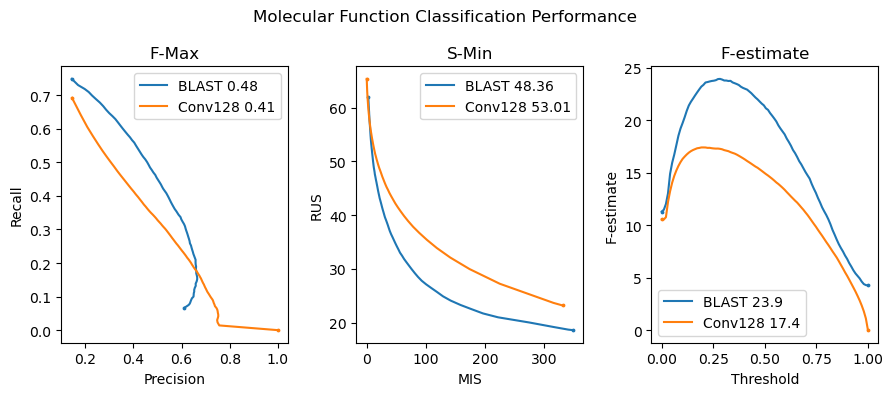

In [22]:
def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Molecular Function Classification Performance")

# base_models = ["BLAST", "Conv", "BERT-Emb", "BERT-FT", "Naive"]
# disp_info = {
#     "BLAST": colors[0],
#     "Conv": colors[1],
#     "BERT-Emb": colors[-1],
#     "BERT-FT": colors[2],
#     "Naive": colors[4]
# }
for model_name, stats in model_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}")
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}")
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

# axes[0].set_xlim([0.25, 1])
# axes[0].set_ylim([0, 0.9])
# axes[1].set_xlim([-3, 50])
# axes[1].set_ylim([2, 20])
# axes[2].set_xlim([0, 1.1])
# axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()